# Per-token metrics

The notebook expects pre-created train, val, and test DataFrames stored in the pickle format in `data/old_datasets` and `data/generated_dataset` folders. All experiment results should be in the folder `data/experiments/`.

## Change-one grid search examination

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
import pandas as pd
import numpy as np
from pathlib import Path

data_folder = Path('../../data')
df = pd.read_csv(data_folder / 'experiments/best_model_comparison2.csv', index_col=0)
df.head()

loss  avs_dist    avs_l1    avs_l2       acc  \
best_model_comparison2                                                     
baseline                2.922262  0.555892  0.231910  0.137884  0.332048   
DDC                     2.712395  0.539461  0.224185  0.132712  0.351711   
Custom vec+id:id        5.706663  0.524830  0.218787  0.129822  0.369083   
Custom vec+id:id        5.724463  0.526978  0.219517  0.130294  0.367316   
MLSTM                   3.626963  0.522084  0.217321  0.128820  0.371808   

                        perplexity  top5_acc  \
best_model_comparison2                         
baseline                 19.371548  0.638555   
DDC                      16.017336  0.669090   
Custom vec+id:id         23.839785  0.685781   
Custom vec+id:id         25.449701  0.683272   
MLSTM                    14.868427  0.691659   

                                                                  history  \
best_model_comparison2                                                      
baseline                {'loss': [4.912832736968994, 4.425121784210205...   
DDC                     {'loss': [4.77817964553833, 4.135108470916748,...   
Custom vec+id:id        {'loss': [6.570437431335449, 6.166257858276367...   
Custom vec+id:id        {'loss': [6.634748458862305, 6.105906963348389...   
MLSTM                   {'loss': [5.898534774780273, 4.466647624969482...   

                            elapsed  \
best_model_comparison2                
baseline                1173.869907   
DDC                      662.858902   
Custom vec+id:id         847.529622   
Custom vec+id:id        1083.473060   
MLSTM                   1543.521549   

                                                                   config  
best_model_comparison2                                                     
baseline                Config(audio_processing=AudioProcessingConfig(...  
DDC                     Config(audio_processing=AudioProcessingConfig(...  
Custom vec+id:id        Config(audio_processing=AudioProcessingConfig(...  
Custom vec+id:id        Config(audio_processing=AudioProcessingConfig(...  
MLSTM                   Config(audio_processing=AudioProcessingConfig(...

In [2]:
def get_stats(df):
    ser = pd.Series()
    for col in df.select_dtypes(include=np.number).columns:
        ser[f'{col}_mean'] = df[col].mean()
        ser[f'{col}_std'] = df[col].std()
    return ser
    
res = df.groupby(df.index).apply(get_stats)
res.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


loss_mean  loss_std  avs_dist_mean  avs_dist_std  \
best_model_comparison2                                                     
Custom vec+id:id         5.709885  0.006998       0.524287      0.001309   
Custom vec+id:vec        0.058029  0.000665       0.308366      0.003225   
DDC                      2.727013  0.019819       0.540840      0.001041   

                        avs_l1_mean  avs_l1_std  avs_l2_mean  avs_l2_std  \
best_model_comparison2                                                     
Custom vec+id:id           0.218630    0.000550     0.129800    0.000397   
Custom vec+id:vec          0.171866    0.002081     0.058029    0.000665   
DDC                        0.225111    0.000501     0.133538    0.000398   

                        acc_mean   acc_std  perplexity_mean  perplexity_std  \
best_model_comparison2                                                        
Custom vec+id:id        0.370124  0.001502        24.447216        0.534579   
Custom vec+id:vec       0.328846  0.007536              inf             NaN   
DDC                     0.350429  0.001372        16.275832        0.354383   

                        top5_acc_mean  top5_acc_std  elapsed_mean  elapsed_std  
best_model_comparison2                                                          
Custom vec+id:id             0.685613      0.001439    970.385211    63.199645  
Custom vec+id:vec            0.563575      0.006448   1426.884825    46.680319  
DDC                          0.667677      0.001800    705.241020    49.188943

In [64]:
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import re
import math

    
def plot_col(df, col, ylabel='', name=''):
    barWidth = 0.7
    mean = df[f'{col}_mean']
    norm_mean = mean / mean.min()
    yer = df[f'{col}_std'] * 2
    yer = yer.fillna(0)

    # The x position of bars
    x_pos = np.arange(len(mean))
    bot, top = (mean - yer).min(), (mean + yer).max()
    padding = (top - bot) * 0.1
    bot, top = bot - padding, top + padding
    
    
    fig = plt.figure(None, figsize=(16, 6,))
    
    ax = fig.add_subplot(1, 1, 1)
    
    # Create bars
    ax.bar(x_pos, mean, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer, capsize=7, label=f'{col}')

    # General layout
    ax.set_xticks([x for x in range(len(mean))]) # , df.index
#     ax.set_xticklabels([',\n'.join(str(x).split(',')) for x in df.index])
    ax.set_xticklabels([re.sub("['\[\]()]", '',
        re.sub(',', '\n', str(x))) for x in df.index])
    ax.set_xlabel(df.index.name)
    ax.set_ylabel(ylabel)
    ax.set_ylim(bot, top)
    ax.set_ylabel(f'Absolute value [{col}]')
    ax.set_title(name)
    
    ax2 = ax.twinx()

    ax2.set_ylabel('Relative change [%]')

    ax2.set_ylim(bot / mean.min() * 100, top / mean.min() * 100)
    
#     fig.legend()
    fig.show()

def plot_cols(df, cols, name=''):
#     display(Markdown(f'## {df.index.name}'))
    groupped_df = df.groupby(df.index).apply(get_stats)
    groupped_df[~groupped_df.applymap(lambda x: math.isfinite(x))] = None  # drop Nan, inf, etc.
    for col in cols:
        if col in df.columns:
            plot_col(groupped_df, col, name=name)

6.00 runs per hyperparam option   dense_repetition_tapering.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


7.60 runs per hyperparam option      best_model_comparison2.csv
7.00 runs per hyperparam option   vecinformation_comparison.csv
6.29 runs per hyperparam option       best_model_comparison.csv
7.00 runs per hyperparam option              cnn_repetition.csv
7.00 runs per hyperparam option                     dropout.csv
1.43 runs per hyperparam option         baseline_model_size.csv
7.00 runs per hyperparam option                  model_size.csv
3.25 runs per hyperparam option      information_comparison.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3.00 runs per hyperparam option label_smoothing:mixup_alpha.csv
7.71 runs per hyperparam option                    x_groups.csv
3.00 runs per hyperparam option             label_smoothing.csv
7.00 runs per hyperparam option             lstm_repetition.csv
3.00 runs per hyperparam option                 mixup_alpha.csv
7.00 runs per hyperparam option            dense_repetition.csv
4.50 runs per hyperparam option   id_information_comparison.csv
7.70 runs per hyperparam option     information_comparison2.csv
1.71 runs per hyperparam option    baseline_model_size_fail.csv


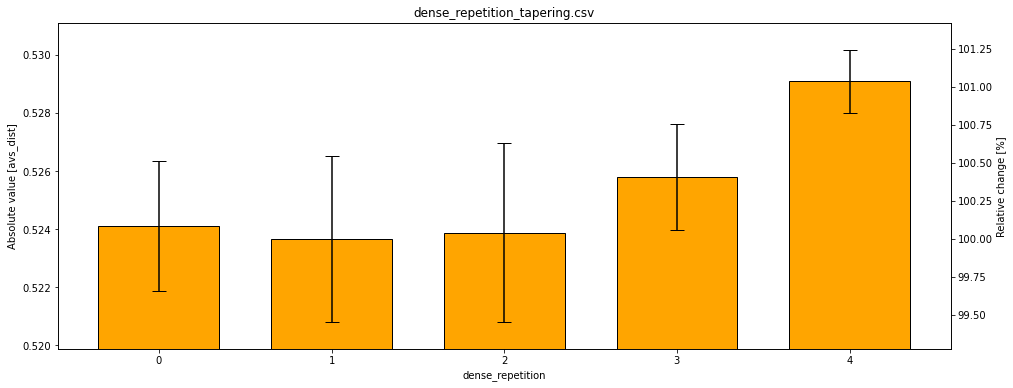

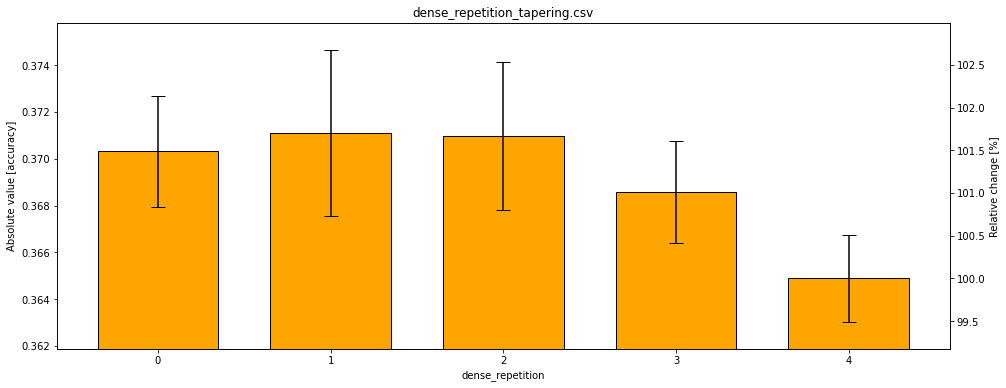

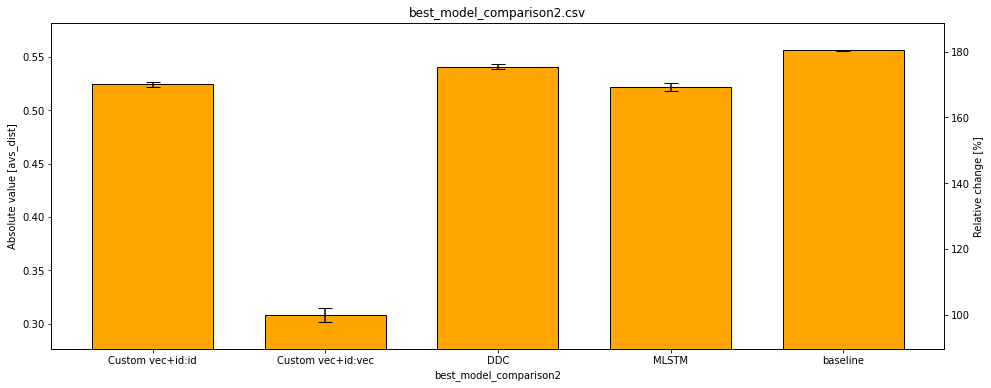

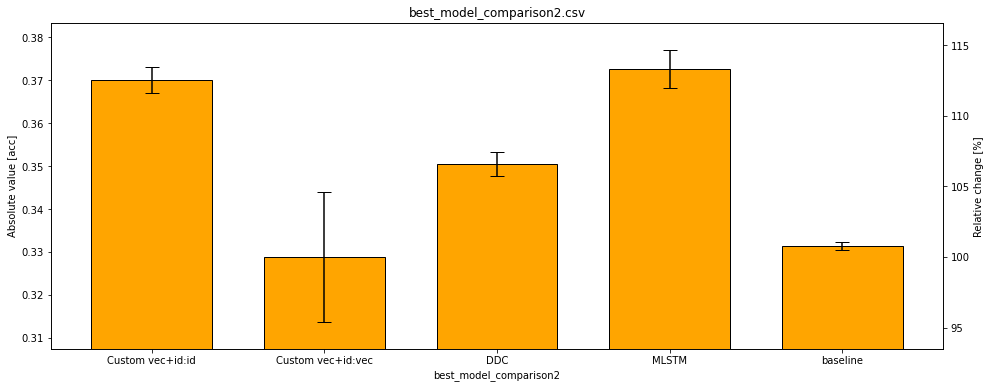

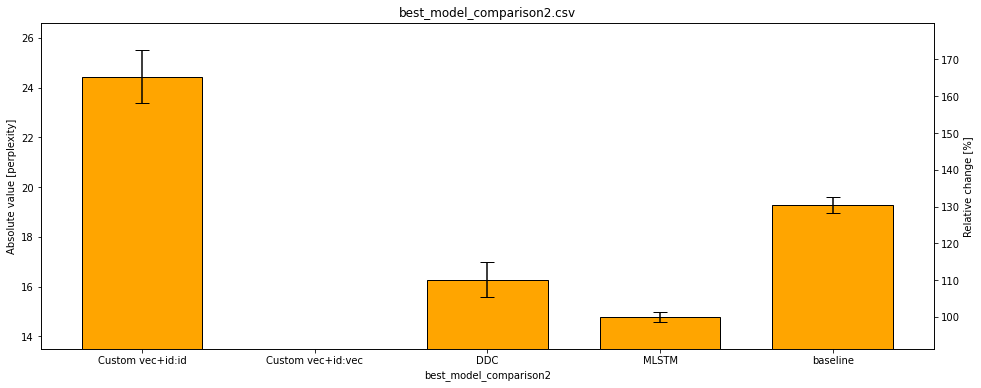

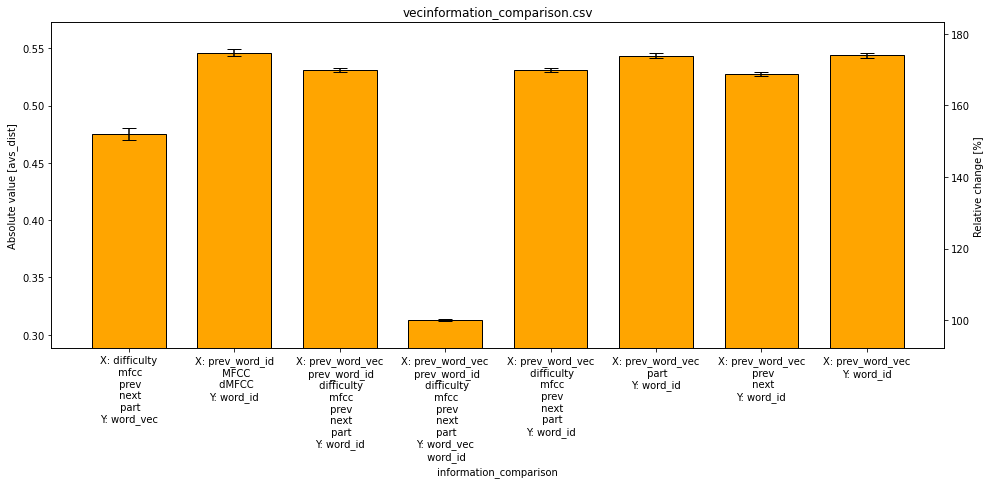

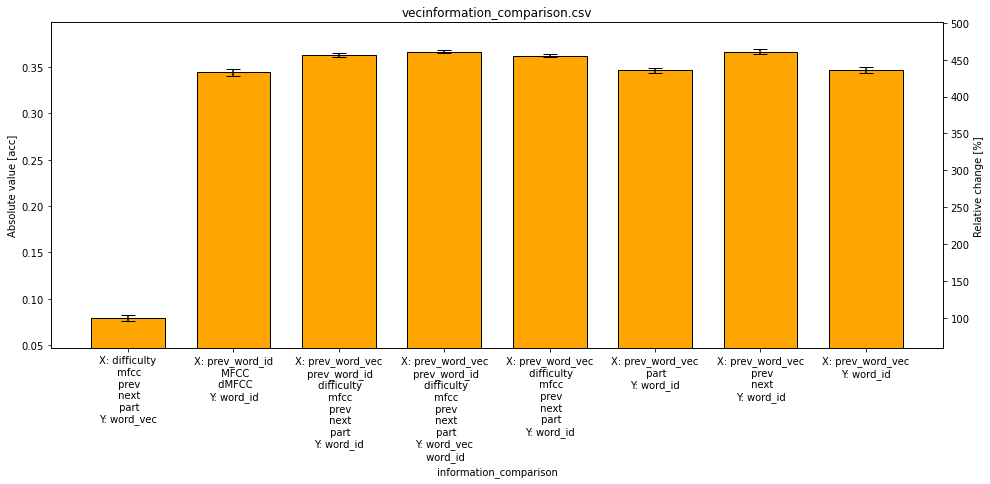

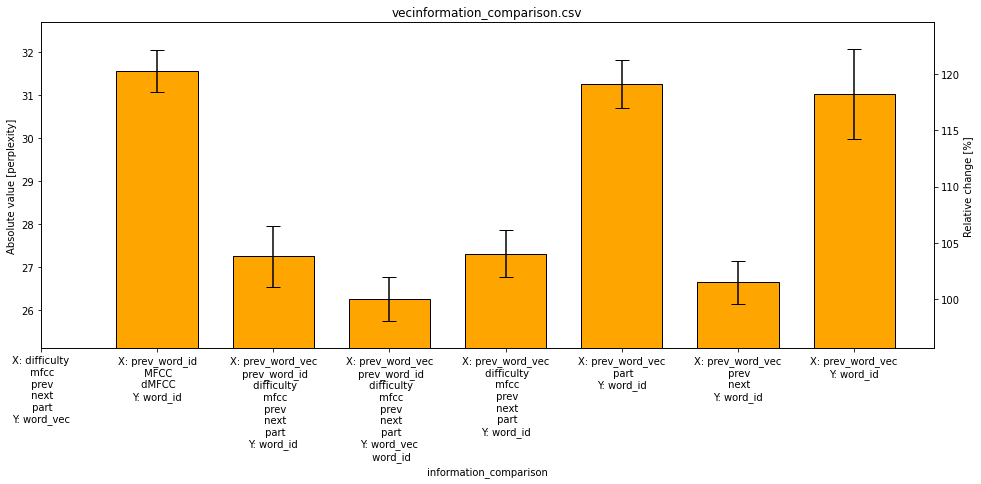

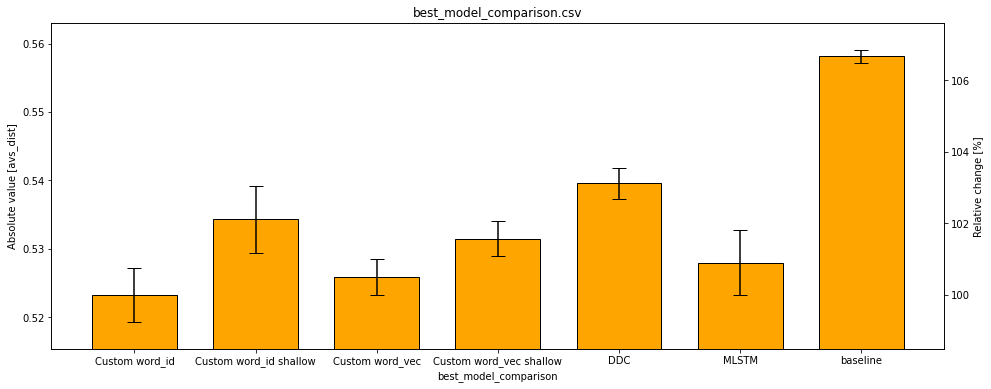

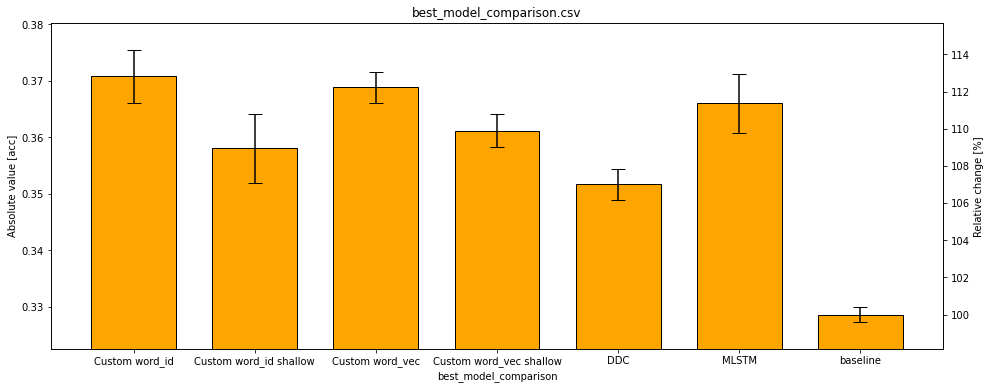

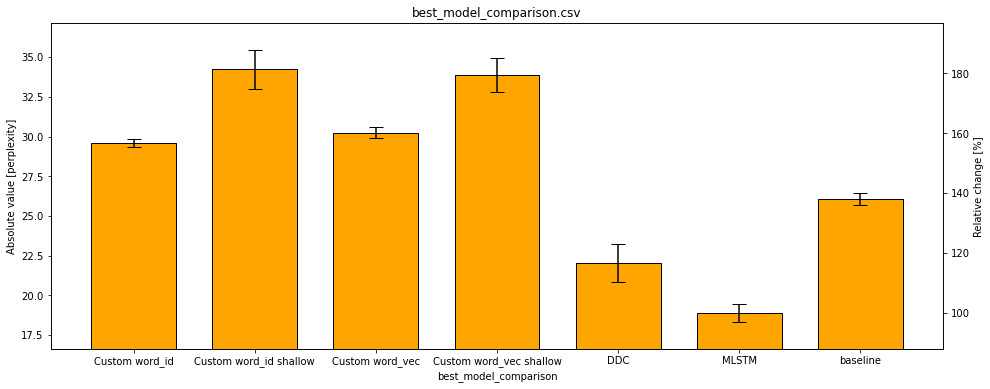

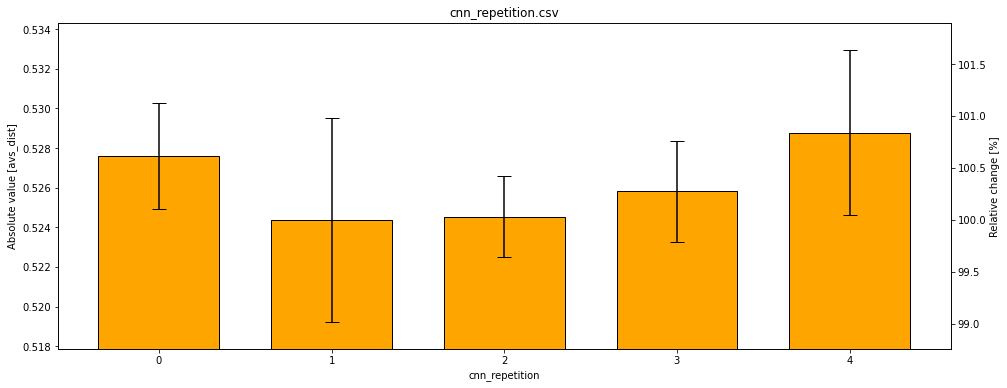

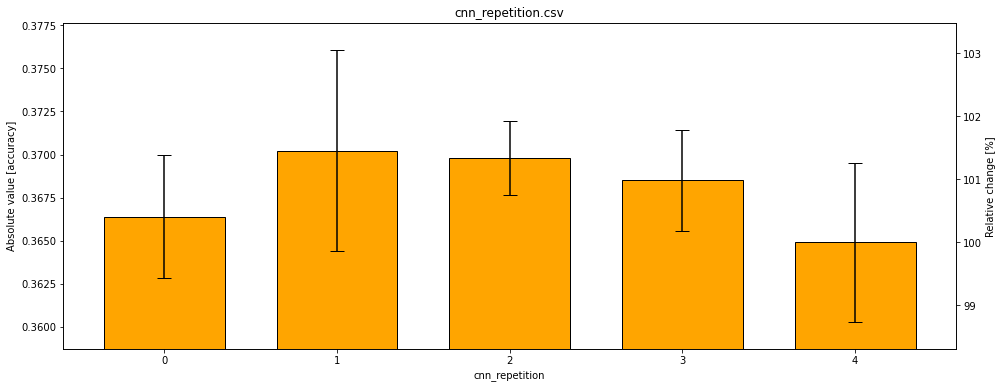

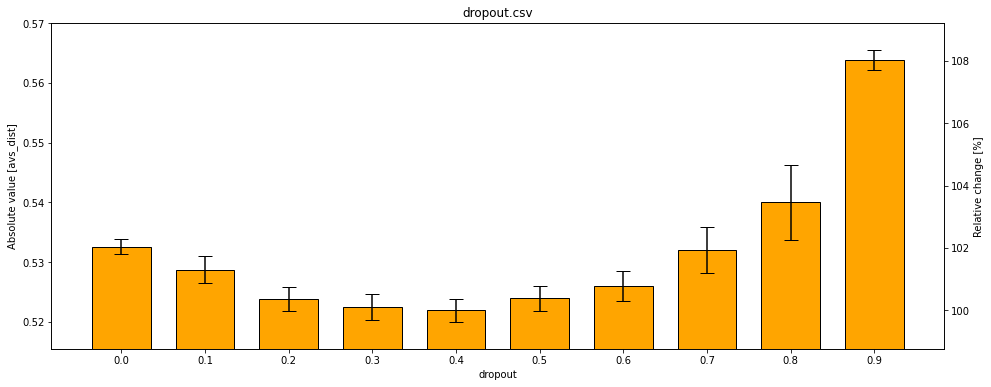

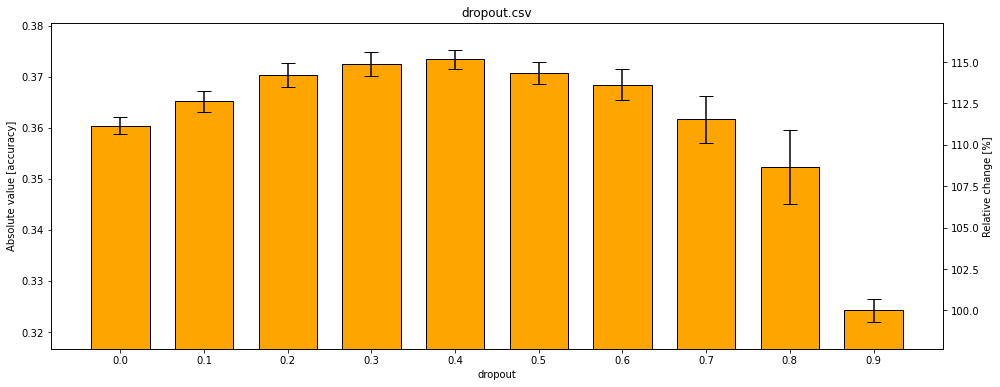

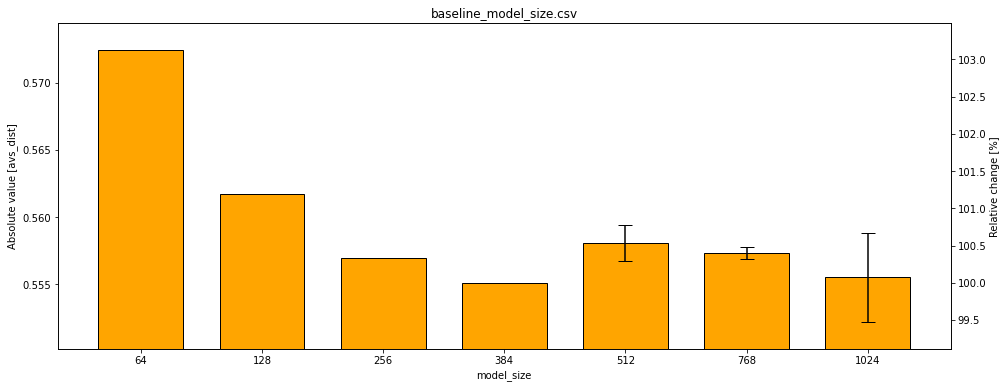

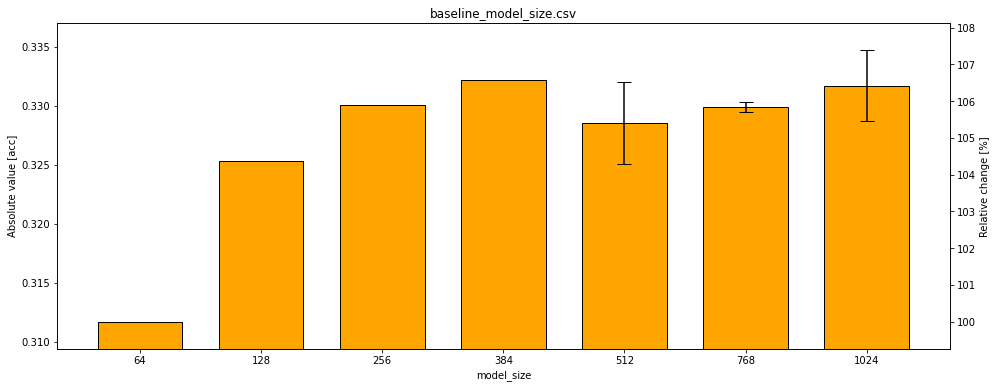

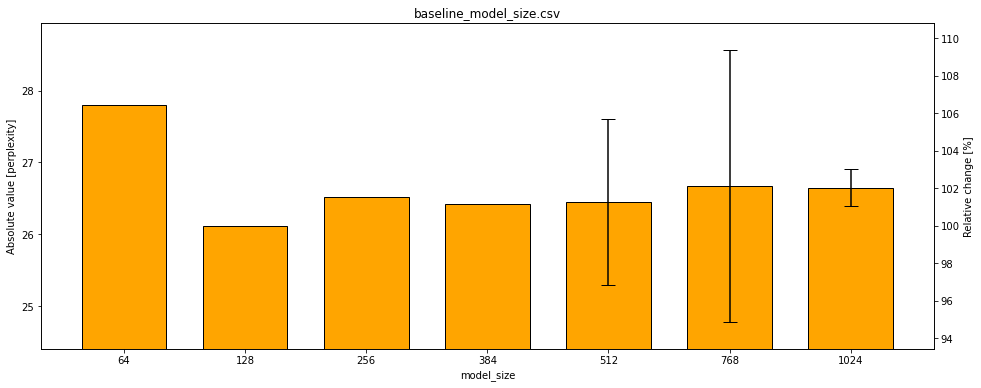

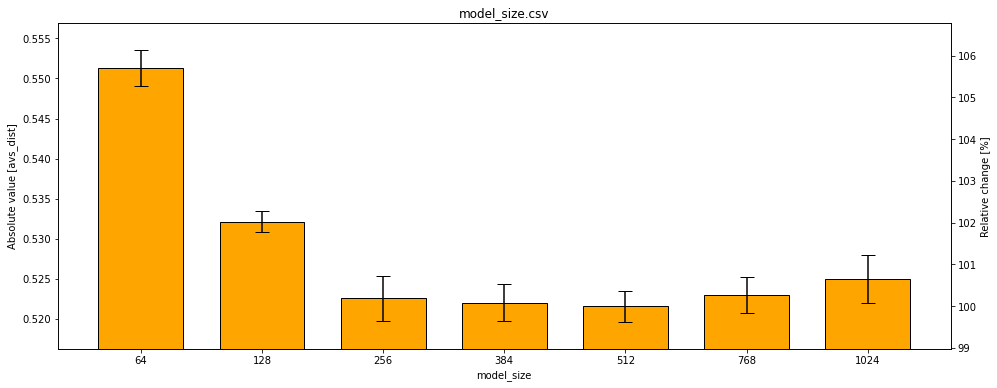

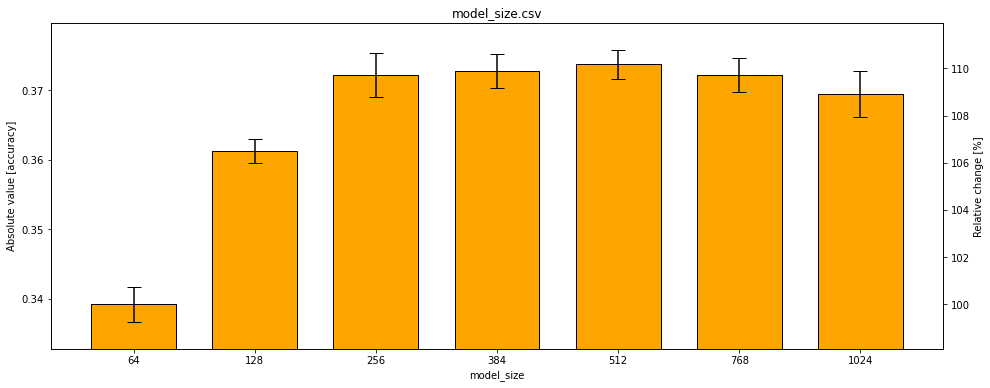

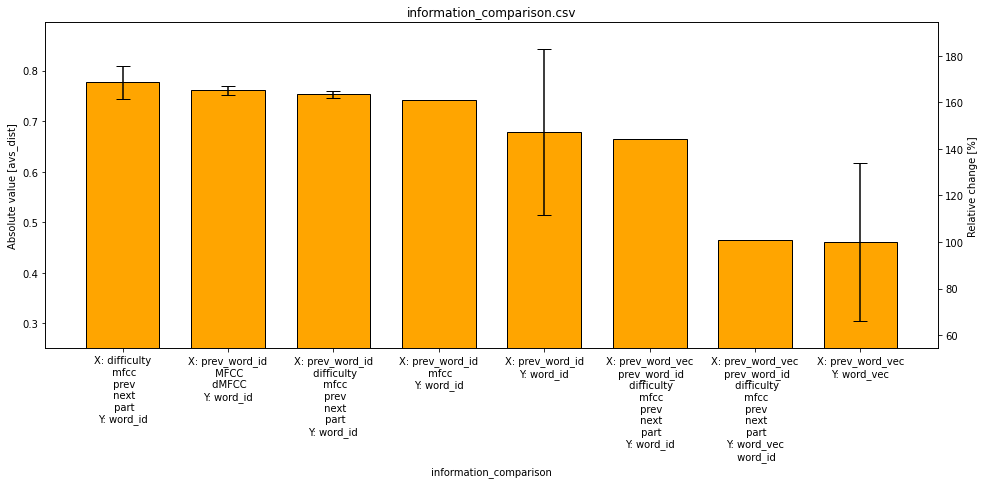

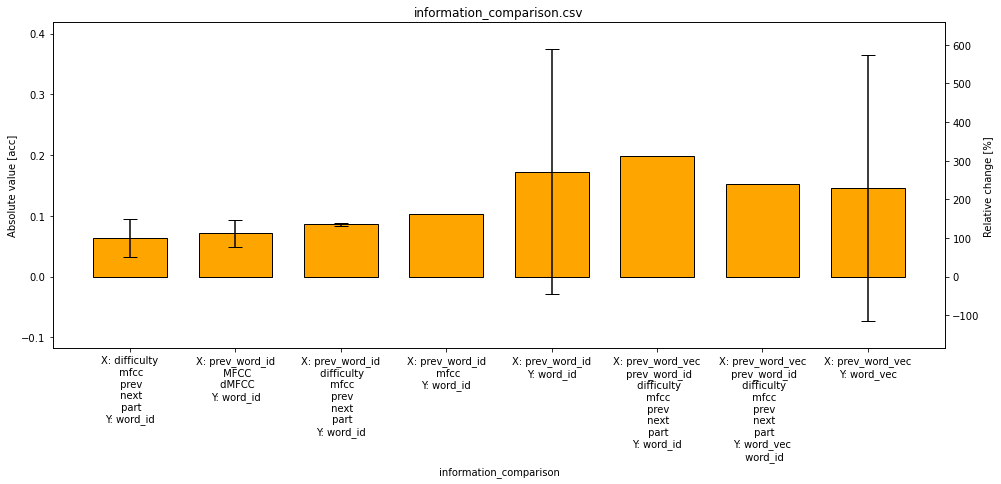

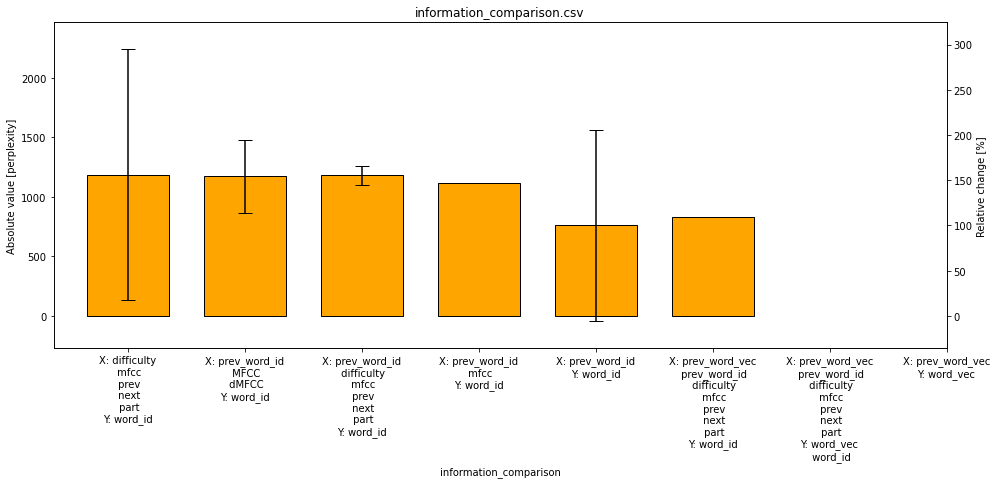

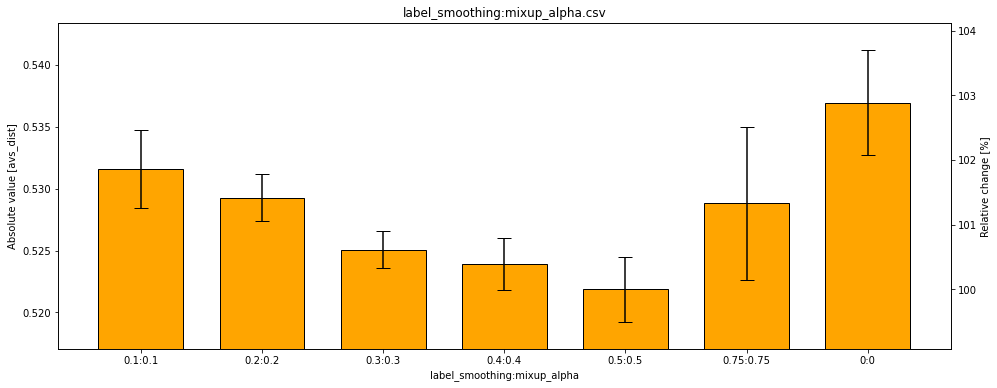

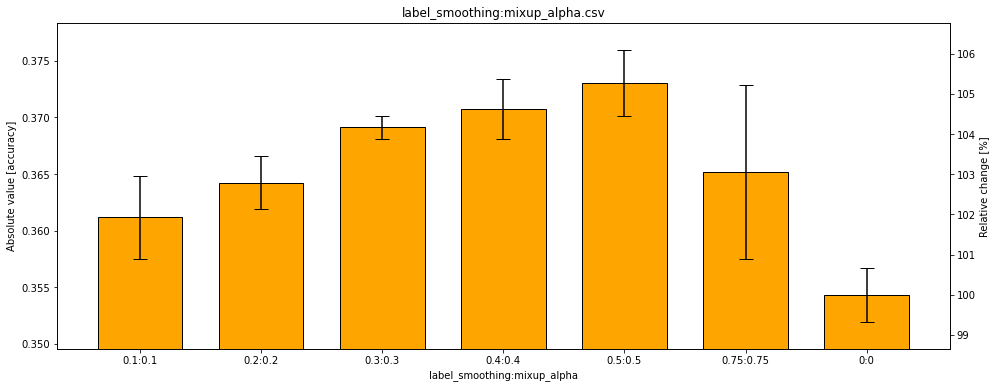

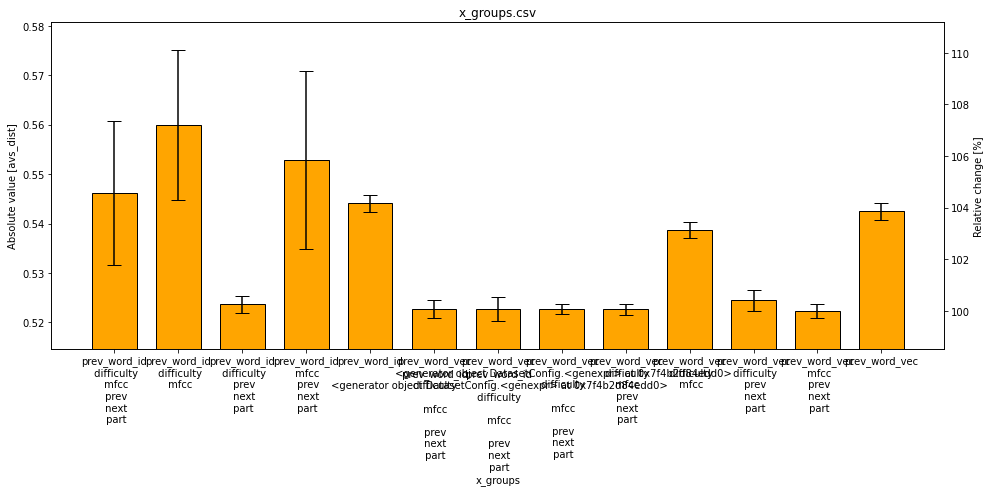

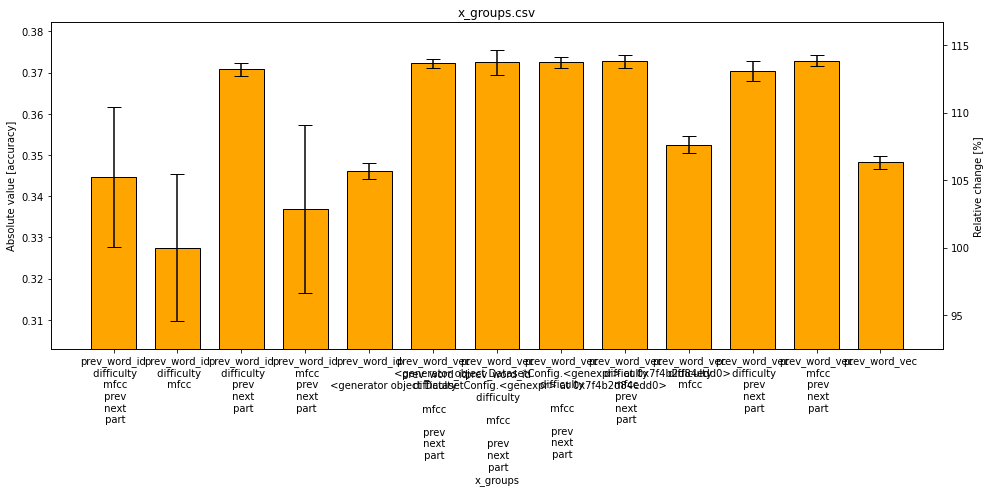

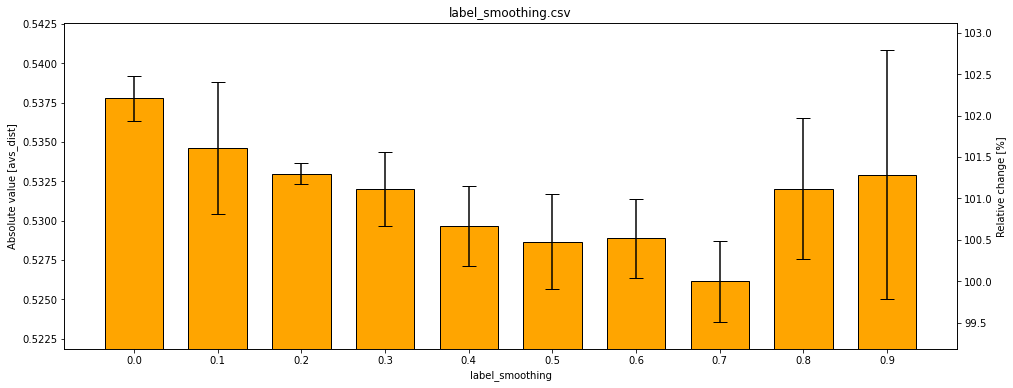

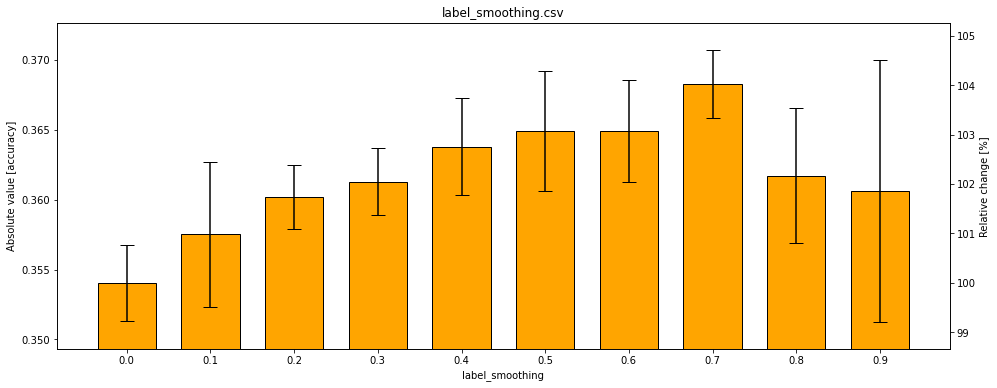

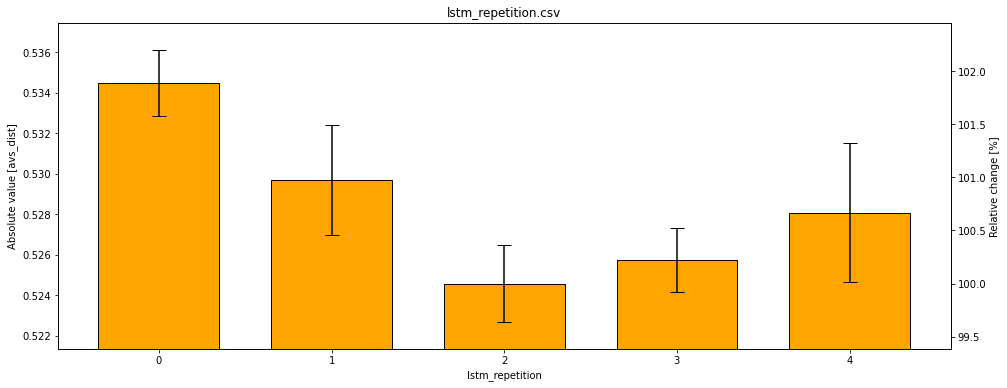

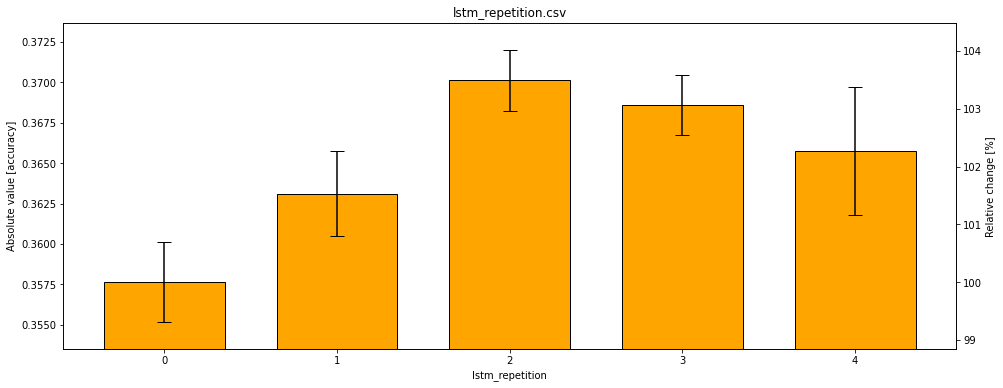

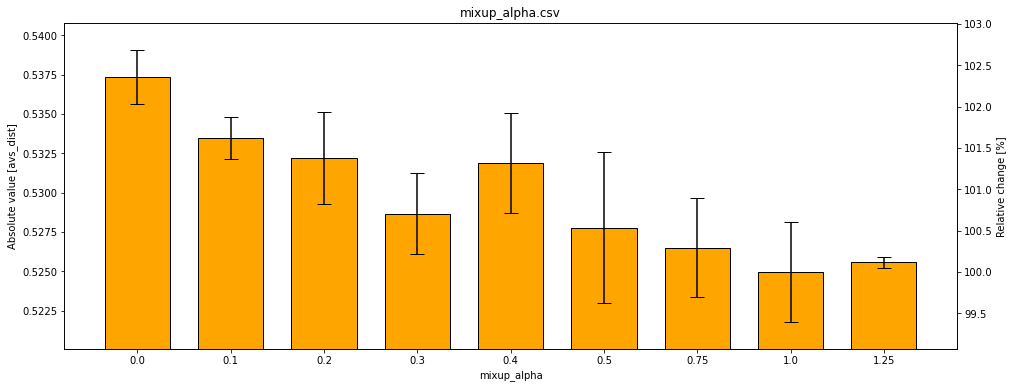

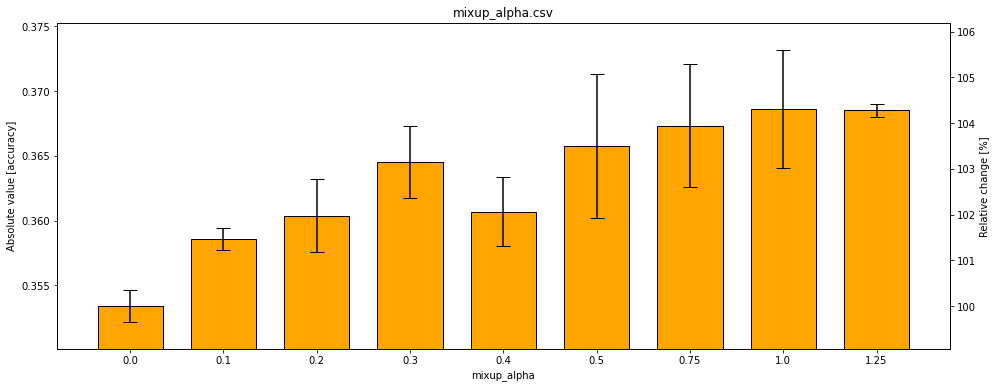

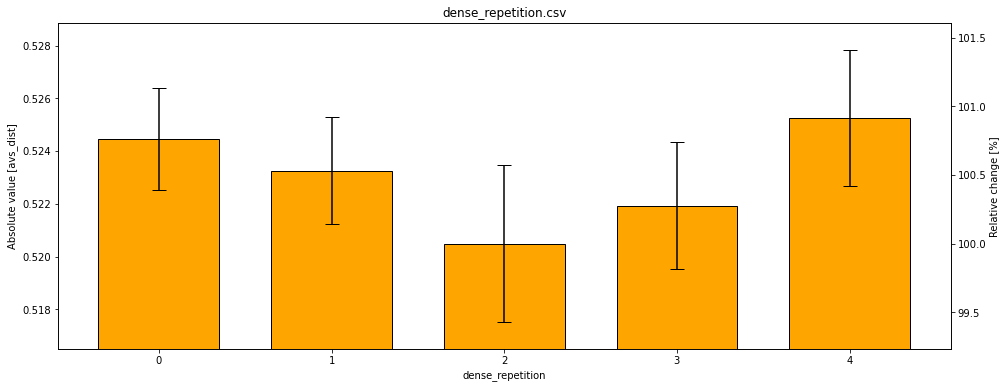

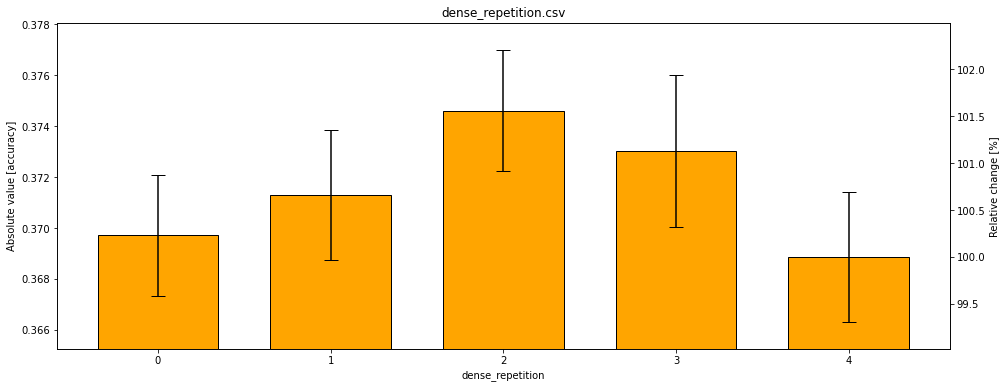

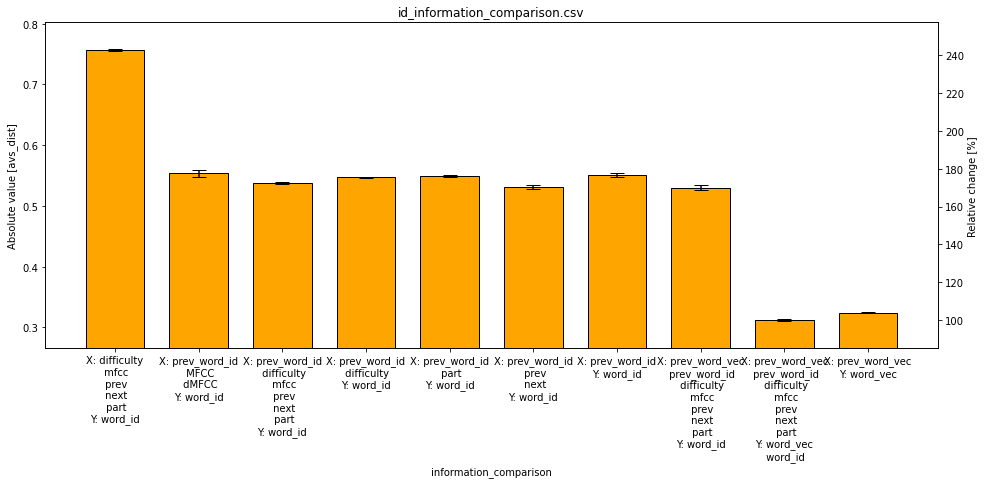

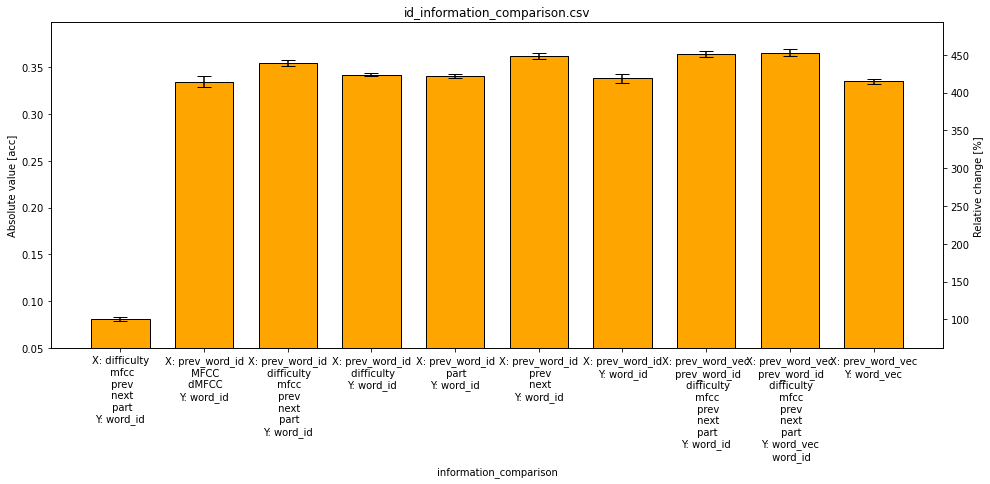

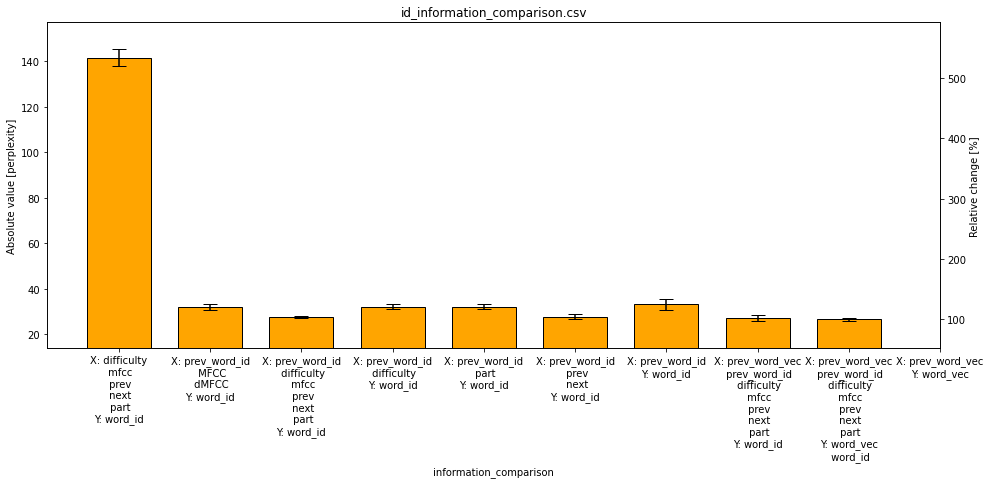

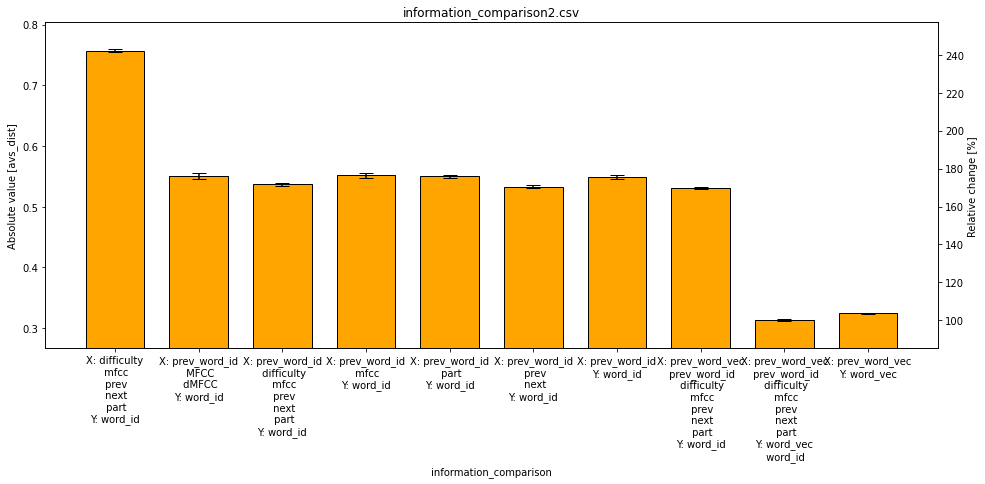

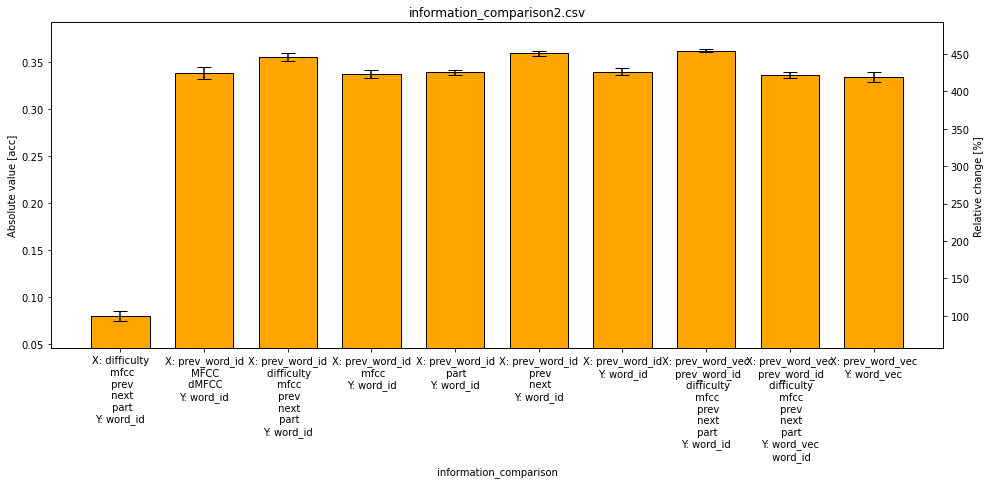

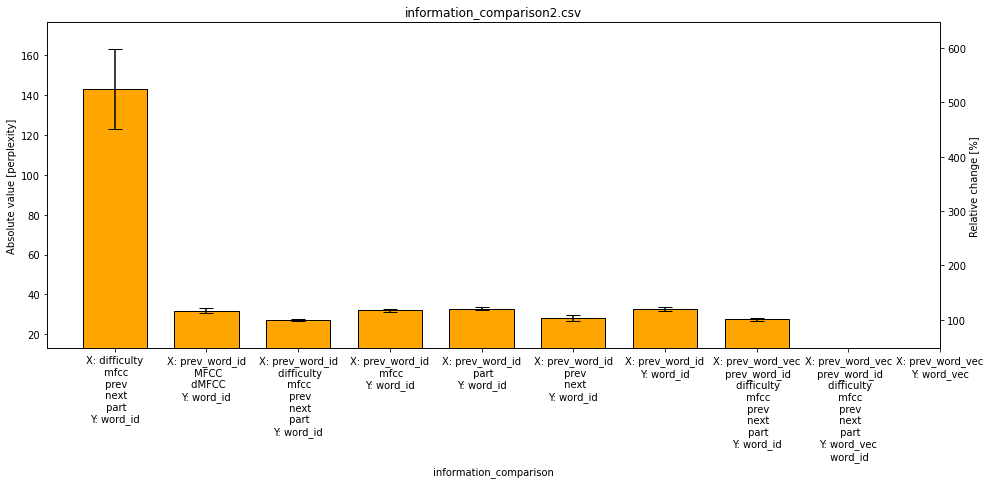

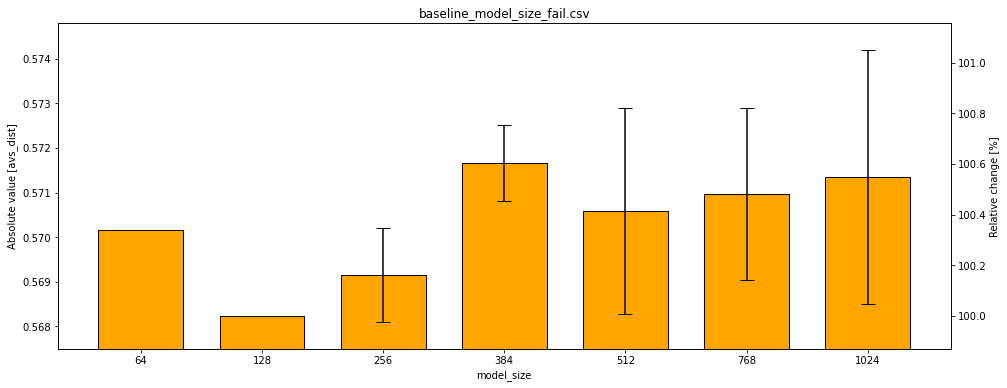

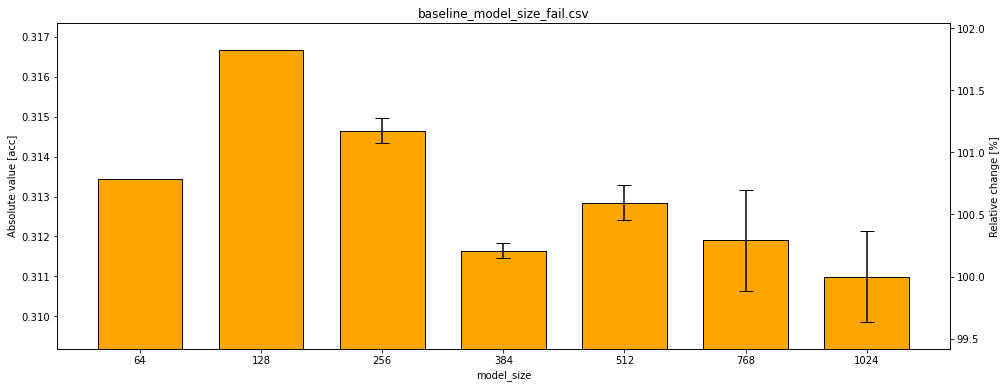

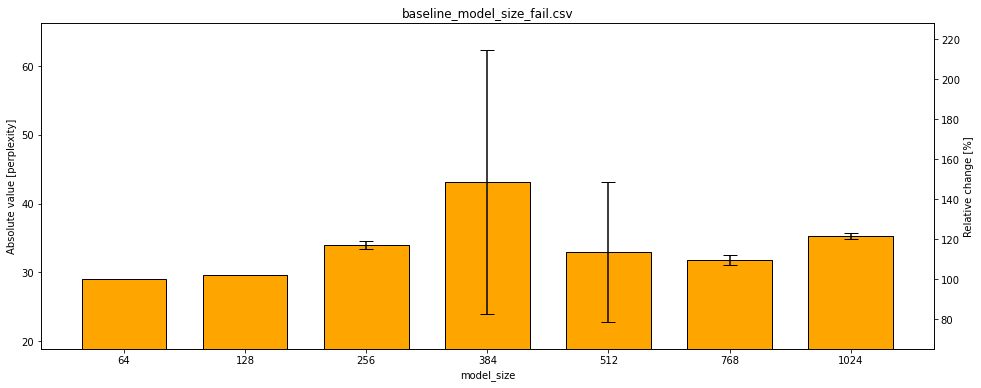

In [4]:
from pathlib import Path

experiments_path = data_folder / 'experiments'
for path in experiments_path.iterdir():
    if path.is_file() and path.suffix == '.csv':
        df = pd.read_csv(path, index_col=0)
        print(f'{len(df) / len(df.index.unique()):2.2f} runs per hyperparam option {str(path.name):>31}')
        plot_cols(df, ['avs_dist', 'accuracy', 'acc', 'perplexity'], path.name)

## Table comparison
Ready to be copied to the thesis!
### Models comparison

In [5]:
df = pd.read_csv(data_folder / 'experiments/best_model_comparison2.csv', index_col=0)
df['acc'] *= 100
df['top5_acc'] *= 100
res = df.groupby(df.index).apply(get_stats)
res.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


loss_mean  loss_std  avs_dist_mean  avs_dist_std  \
best_model_comparison2                                                     
Custom vec+id:id         5.709885  0.006998       0.524287      0.001309   
Custom vec+id:vec        0.058029  0.000665       0.308366      0.003225   
DDC                      2.727013  0.019819       0.540840      0.001041   
MLSTM                    3.619841  0.007295       0.521798      0.001981   
baseline                 2.917539  0.007823       0.556153      0.000211   

                        avs_l1_mean  avs_l1_std  avs_l2_mean  avs_l2_std  \
best_model_comparison2                                                     
Custom vec+id:id           0.218630    0.000550     0.129800    0.000397   
Custom vec+id:vec          0.171866    0.002081     0.058029    0.000665   
DDC                        0.225111    0.000501     0.133538    0.000398   
MLSTM                      0.217598    0.000918     0.129182    0.000662   
baseline                   0.232177    0.000249     0.138028    0.000265   

                         acc_mean   acc_std  perplexity_mean  perplexity_std  \
best_model_comparison2                                                         
Custom vec+id:id        37.012355  0.150249        24.447216        0.534579   
Custom vec+id:vec       32.884627  0.753556              inf             NaN   
DDC                     35.042948  0.137162        16.275832        0.354383   
MLSTM                   37.256672  0.223542        14.783323        0.096190   
baseline                33.137963  0.044302        19.267841        0.162474   

                        top5_acc_mean  top5_acc_std  elapsed_mean  elapsed_std  
best_model_comparison2                                                          
Custom vec+id:id            68.561306      0.143861    970.385211    63.199645  
Custom vec+id:vec           56.357511      0.644767   1426.884825    46.680319  
DDC                         66.767716      0.179954    705.241020    49.188943  
MLSTM                       69.341498      0.152962   1667.266482   293.426166  
baseline                    63.819262      0.127631   1152.308344    65.415489

In [6]:
def formate4latex(res_df, col_formatting):
    res_dict = {}
    for col in col_formatting.keys():
        res_dict[col] = res_df[f'{col}_mean'].apply(lambda x: f'{x:.{col_formatting[col][0]}f}')
        if f'{col}_std' in res_df.columns:
            res_dict[col] += '$\pm ' + res_df[f'{col}_std'].apply(lambda x: f'{x:.{col_formatting[col][1]}f}') + '$'

    df_print = pd.DataFrame(res_dict)[col_formatting.keys()]
    return df_print

col_formatting = {
    'perplexity': (1, 2),
    'acc': (1, 2),
    'top5_acc': (1, 2),
    'avs_dist': (3, 3),
    'elapsed': (0, 0),
}
df_print = formate4latex(res, col_formatting)
df_print = df_print.reindex(index=['baseline', 'DDC', 'Custom vec+id:id', 'Custom vec+id:vec', 'MLSTM'])
print(str(df_print))
df_print

                            perplexity             acc        top5_acc  \
best_model_comparison2                                                   
baseline                19.3$\pm 0.16$  33.1$\pm 0.04$  63.8$\pm 0.13$   
DDC                     16.3$\pm 0.35$  35.0$\pm 0.14$  66.8$\pm 0.18$   
Custom vec+id:id        24.4$\pm 0.53$  37.0$\pm 0.15$  68.6$\pm 0.14$   
Custom vec+id:vec         inf$\pm nan$  32.9$\pm 0.75$  56.4$\pm 0.64$   
MLSTM                   14.8$\pm 0.10$  37.3$\pm 0.22$  69.3$\pm 0.15$   

                                avs_dist        elapsed  
best_model_comparison2                                   
baseline                0.556$\pm 0.000$   1152$\pm 65$  
DDC                     0.541$\pm 0.001$    705$\pm 49$  
Custom vec+id:id        0.524$\pm 0.001$    970$\pm 63$  
Custom vec+id:vec       0.308$\pm 0.003$   1427$\pm 47$  
MLSTM                   0.522$\pm 0.002$  1667$\pm 293$  


perplexity             acc        top5_acc  \
best_model_comparison2                                                   
baseline                19.3$\pm 0.16$  33.1$\pm 0.04$  63.8$\pm 0.13$   
DDC                     16.3$\pm 0.35$  35.0$\pm 0.14$  66.8$\pm 0.18$   
Custom vec+id:id        24.4$\pm 0.53$  37.0$\pm 0.15$  68.6$\pm 0.14$   
Custom vec+id:vec         inf$\pm nan$  32.9$\pm 0.75$  56.4$\pm 0.64$   
MLSTM                   14.8$\pm 0.10$  37.3$\pm 0.22$  69.3$\pm 0.15$   

                                avs_dist        elapsed  
best_model_comparison2                                   
baseline                0.556$\pm 0.000$   1152$\pm 65$  
DDC                     0.541$\pm 0.001$    705$\pm 49$  
Custom vec+id:id        0.524$\pm 0.001$    970$\pm 63$  
Custom vec+id:vec       0.308$\pm 0.003$   1427$\pm 47$  
MLSTM                   0.522$\pm 0.002$  1667$\pm 293$

### Information performance

In [62]:
# df = pd.read_csv('../../data/experiments/information_comparison2.csv', index_col=0)
df = pd.read_csv(data_folder / 'experiments/id_information_comparison.csv', index_col=0)
df['acc'] *= 100
df['top5_acc'] *= 100
res = df.groupby(df.index).apply(get_stats)
res.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


loss_mean  loss_std  \
information_comparison                                                    
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...   6.499435  0.007493   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...   5.831618  0.008882   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...   5.761604  0.006184   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...   5.826289  0.006114   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]    5.830250  0.006051   

                                                    avs_dist_mean  \
information_comparison                                              
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...       0.756287   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...       0.554013   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...       0.537511   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...       0.547465   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]        0.549128   

                                                    avs_dist_std  avs_l1_mean  \
information_comparison                                                          
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...      0.000586     0.306475   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...      0.002832     0.231218   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...      0.000972     0.223981   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...      0.000421     0.228939   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]       0.001136     0.229187   

                                                    avs_l1_std  avs_l2_mean  \
information_comparison                                                        
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...    0.002215     0.175631   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...    0.001132     0.137503   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...    0.000216     0.132906   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...    0.000240     0.136196   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]     0.000603     0.136264   

                                                    avs_l2_std   acc_mean  \
information_comparison                                                      
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...    0.002153   8.068588   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...    0.000741  33.456832   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...    0.000043  35.405653   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...    0.000254  34.171472   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]     0.000415  33.999252   

                                                     acc_std  perplexity_mean  \
information_comparison                                                          
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  0.103859       141.610431   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  0.293729        32.006621   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...  0.162830        27.539806   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...  0.071767        32.002505   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]   0.107388        32.122193   

                                                    perplexity_std  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...        1.828731   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...        0.688701   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...        0.288899   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...        0.518689   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]         0.635797   

                                                    top5_acc_mean  \
information_comparison                                              
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...      27.364882   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...      64.191839   
X: [['prev_word_id'], ['difficulty', 'mfcc', 

In [63]:
col_formatting = {
    'perplexity': (1, 2),
    'acc': (1, 2),
    'top5_acc': (1, 2),
    'avs_dist': (3, 3),
    'elapsed': (0, 0),
}
df_print = formate4latex(res, col_formatting)
# df_print = df_print.reindex(index=['baseline', 'DDC', 'Custom vec+id:id', 'Custom vec+id:vec', 'MLSTM'])
df_print = df_print.loc[res.sort_values('top5_acc_mean').index]
print(str(df_print.reset_index(drop=True)))
df_print

        perplexity             acc        top5_acc          avs_dist  \
0  141.6$\pm 1.83$   8.1$\pm 0.10$  27.4$\pm 0.38$  0.756$\pm 0.001$   
1     inf$\pm nan$  33.5$\pm 0.14$  55.2$\pm 0.13$  0.324$\pm 0.000$   
2   32.0$\pm 0.69$  33.5$\pm 0.29$  64.2$\pm 0.25$  0.554$\pm 0.003$   
3   33.1$\pm 1.25$  33.8$\pm 0.24$  64.2$\pm 0.41$  0.551$\pm 0.002$   
4   32.1$\pm 0.64$  34.0$\pm 0.11$  64.6$\pm 0.10$  0.549$\pm 0.001$   
5   32.0$\pm 0.52$  34.2$\pm 0.07$  64.6$\pm 0.20$  0.547$\pm 0.000$   
6   27.5$\pm 0.29$  35.4$\pm 0.16$  67.0$\pm 0.25$  0.538$\pm 0.001$   
7   27.5$\pm 0.55$  36.2$\pm 0.17$  67.5$\pm 0.28$  0.531$\pm 0.002$   
8   27.1$\pm 0.71$  36.4$\pm 0.17$  68.0$\pm 0.41$  0.530$\pm 0.002$   
9   26.5$\pm 0.28$  36.5$\pm 0.17$  68.2$\pm 0.36$  0.312$\pm 0.001$   

        elapsed  
0   318$\pm 62$  
1   229$\pm 19$  
2  520$\pm 200$  
3   420$\pm 55$  
4   428$\pm 64$  
5   410$\pm 44$  
6   481$\pm 37$  
7   403$\pm 51$  
8   381$\pm 40$  
9   446$\pm 65$  


perplexity  \
information_comparison                                                
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  141.6$\pm 1.83$   
X: [['prev_word_vec']]\nY: [['word_vec']]              inf$\pm nan$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...   32.0$\pm 0.69$   
X: [['prev_word_id']]\nY: [['word_id']]              33.1$\pm 1.25$   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]    32.1$\pm 0.64$   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...   32.0$\pm 0.52$   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...   27.5$\pm 0.29$   
X: [['prev_word_id'], ['prev', 'next']]\nY: [['...   27.5$\pm 0.55$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...   27.1$\pm 0.71$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...   26.5$\pm 0.28$   

                                                               acc  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...   8.1$\pm 0.10$   
X: [['prev_word_vec']]\nY: [['word_vec']]           33.5$\pm 0.14$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  33.5$\pm 0.29$   
X: [['prev_word_id']]\nY: [['word_id']]             33.8$\pm 0.24$   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]   34.0$\pm 0.11$   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...  34.2$\pm 0.07$   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...  35.4$\pm 0.16$   
X: [['prev_word_id'], ['prev', 'next']]\nY: [['...  36.2$\pm 0.17$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  36.4$\pm 0.17$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  36.5$\pm 0.17$   

                                                          top5_acc  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  27.4$\pm 0.38$   
X: [['prev_word_vec']]\nY: [['word_vec']]           55.2$\pm 0.13$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  64.2$\pm 0.25$   
X: [['prev_word_id']]\nY: [['word_id']]             64.2$\pm 0.41$   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]   64.6$\pm 0.10$   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...  64.6$\pm 0.20$   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...  67.0$\pm 0.25$   
X: [['prev_word_id'], ['prev', 'next']]\nY: [['...  67.5$\pm 0.28$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  68.0$\pm 0.41$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  68.2$\pm 0.36$   

                                                            avs_dist  \
information_comparison                                                 
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  0.756$\pm 0.001$   
X: [['prev_word_vec']]\nY: [['word_vec']]           0.324$\pm 0.000$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  0.554$\pm 0.003$   
X: [['prev_word_id']]\nY: [['word_id']]             0.551$\pm 0.002$   
X: [['prev_word_id'], ['part']]\nY: [['word_id']]   0.549$\pm 0.001$   
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...  0.547$\pm 0.000$   
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...  0.538$\pm 0.001$   
X: [['prev_word_id'], ['prev', 'next']]\nY: [['...  0.531$\pm 0.002$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  0.530$\pm 0.002$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  0.312$\pm 0.001$   

                                                         elapsed  
information_comparison                                            
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...   318$\pm 62$  
X: [['prev_word_vec']]\nY: [['word_vec']]            229$\pm 19$  
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  520$\pm 200$  
X: [['prev_word_id']]\nY: [['word_id']]              420$\pm 55$  
X: [['prev_word_id'], ['part']]\nY: [['word_id']]    428$\pm 64$  
X: [['prev_word_id'], ['difficulty']]\nY: [['wo...   410$\pm 44$  
X: [['prev_word_id'], ['difficulty', 'mfcc', 'p...   481$\pm 37$  
X: [['prev_word_id'], ['prev', 'next']]\nY: [['...   4

In [9]:
df = pd.read_csv(data_folder / 'experiments/vecinformation_comparison.csv', index_col=0)
df['acc'] *= 100
df['top5_acc'] *= 100
res = df.groupby(df.index).apply(get_stats)

col_formatting = {
    'perplexity': (1, 2),
    'acc': (1, 2),
    'top5_acc': (1, 2),
    'avs_dist': (3, 3),
    'elapsed': (0, 0),
}
df_print = formate4latex(res, col_formatting)
# df_print = df_print.reindex(index=['baseline', 'DDC', 'Custom vec+id:id', 'Custom vec+id:vec', 'MLSTM'])
print(str(df_print.reset_index(drop=True)))
df_print.loc[res.sort_values('acc_mean').index]
# df_print.sort_values('acc_mean')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


       perplexity             acc        top5_acc          avs_dist  \
0    inf$\pm nan$   7.9$\pm 0.18$  25.4$\pm 0.29$  0.476$\pm 0.003$   
1  31.6$\pm 0.24$  34.4$\pm 0.19$  65.3$\pm 0.29$  0.546$\pm 0.001$   
2  27.2$\pm 0.35$  36.3$\pm 0.09$  68.0$\pm 0.19$  0.531$\pm 0.001$   
3  26.2$\pm 0.26$  36.6$\pm 0.07$  68.3$\pm 0.10$  0.313$\pm 0.001$   
4  27.3$\pm 0.28$  36.2$\pm 0.09$  67.8$\pm 0.12$  0.531$\pm 0.001$   
5  31.3$\pm 0.28$  34.6$\pm 0.12$  65.4$\pm 0.20$  0.544$\pm 0.001$   
6  26.6$\pm 0.25$  36.6$\pm 0.12$  68.3$\pm 0.16$  0.528$\pm 0.001$   
7  31.0$\pm 0.52$  34.7$\pm 0.17$  65.4$\pm 0.18$  0.544$\pm 0.001$   

       elapsed  
0  276$\pm 64$  
1  245$\pm 13$  
2  382$\pm 26$  
3  453$\pm 31$  
4  264$\pm 26$  
5  240$\pm 32$  
6  252$\pm 21$  
7  245$\pm 19$  


perplexity  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...    inf$\pm nan$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  31.6$\pm 0.24$   
X: [['prev_word_vec'], ['part']]\nY: [['word_id']]  31.3$\pm 0.28$   
X: [['prev_word_vec']]\nY: [['word_id']]            31.0$\pm 0.52$   
X: [['prev_word_vec'], ['difficulty', 'mfcc', '...  27.3$\pm 0.28$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  27.2$\pm 0.35$   
X: [['prev_word_vec'], ['prev', 'next']]\nY: [[...  26.6$\pm 0.25$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  26.2$\pm 0.26$   

                                                               acc  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...   7.9$\pm 0.18$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  34.4$\pm 0.19$   
X: [['prev_word_vec'], ['part']]\nY: [['word_id']]  34.6$\pm 0.12$   
X: [['prev_word_vec']]\nY: [['word_id']]            34.7$\pm 0.17$   
X: [['prev_word_vec'], ['difficulty', 'mfcc', '...  36.2$\pm 0.09$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  36.3$\pm 0.09$   
X: [['prev_word_vec'], ['prev', 'next']]\nY: [[...  36.6$\pm 0.12$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  36.6$\pm 0.07$   

                                                          top5_acc  \
information_comparison                                               
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  25.4$\pm 0.29$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  65.3$\pm 0.29$   
X: [['prev_word_vec'], ['part']]\nY: [['word_id']]  65.4$\pm 0.20$   
X: [['prev_word_vec']]\nY: [['word_id']]            65.4$\pm 0.18$   
X: [['prev_word_vec'], ['difficulty', 'mfcc', '...  67.8$\pm 0.12$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  68.0$\pm 0.19$   
X: [['prev_word_vec'], ['prev', 'next']]\nY: [[...  68.3$\pm 0.16$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  68.3$\pm 0.10$   

                                                            avs_dist  \
information_comparison                                                 
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  0.476$\pm 0.003$   
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  0.546$\pm 0.001$   
X: [['prev_word_vec'], ['part']]\nY: [['word_id']]  0.544$\pm 0.001$   
X: [['prev_word_vec']]\nY: [['word_id']]            0.544$\pm 0.001$   
X: [['prev_word_vec'], ['difficulty', 'mfcc', '...  0.531$\pm 0.001$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  0.531$\pm 0.001$   
X: [['prev_word_vec'], ['prev', 'next']]\nY: [[...  0.528$\pm 0.001$   
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  0.313$\pm 0.001$   

                                                        elapsed  
information_comparison                                           
X: [['difficulty', 'mfcc', 'prev', 'next', 'par...  276$\pm 64$  
X: [['prev_word_id'], ['MFCC', 'dMFCC']]\nY: [[...  245$\pm 13$  
X: [['prev_word_vec'], ['part']]\nY: [['word_id']]  240$\pm 32$  
X: [['prev_word_vec']]\nY: [['word_id']]            245$\pm 19$  
X: [['prev_word_vec'], ['difficulty', 'mfcc', '...  264$\pm 26$  
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  382$\pm 26$  
X: [['prev_word_vec'], ['prev', 'next']]\nY: [[...  252$\pm 21$  
X: [['prev_word_vec', 'prev_word_id'], ['diffic...  453$\pm 31$

# Global metrics
## Action velocity distribution distance

AVD distance is defined as

$$B'_w = \{\text{action velocity}_{t, w} | t \in \mathbb N_0, t < |B|\} \text .$$
Action velocity of a set of beat maps $S$ is defined as

$$S'_w = \bigcup\limits_{B \in S} B'_w \text .$$

$$\text {AVD distance}_k = \frac {\text{KS statistic}( F'_1, G'_1) + \ldots + \text{KS statistic}(F'_k, G'_k)}{k} \text .$$


Computed as

```python
def action_velocities(S, window) -> List[float]:
    for B in S:
        for t in range(2 * window, len(B)):
            yield action_velocity(B, window, t)
    
def avd_distance(S0, S1, window) -> float:
    S0_v = action_velocities(S0, window)
    S1_v = action_velocities(S1, window)
    return kolmogorov_smirnov_statistic(S0_v, S1_v)

def avd_distance(S0, S1, k) -> float:
    distances = [avd_distance(S0, S1, w) 
                    for w in range(1, k)]
    return distances.mean()
```

In [10]:
!pip install gensim soundfile speechpy keras-tuner
# Needed for the minimal import from src if not running Jupyter in the Docker image

In [11]:
from pathlib import Path
from typing import Tuple
import sys
from multiprocessing import Pool
from itertools import starmap
import sys
sys.path.append("../") # go to parent dir

in_container = False   # Import the code, if the Jupyter runs in the DeepSaber container with all libs
if in_container:
    from experiments.temperature_search import compute_multiple_velocities, compute_avd_distance
    from experiments.temperature_search import velocities_from_config, compute_avd_distance
else:
    from scipy.stats import ks_2samp

    def compute_ks_statistic(window1, data1, window2, data2):
        assert window1 == window2
        stat = ks_2samp(data1, data2)[0]
        return window1, stat

    def compute_avd_distance(val_velocities, generated_velocities):
        pool = Pool()

        params = [(w1, d1, w2, d2) for (w1, d1), (w2, d2) in zip(val_velocities.items(), generated_velocities.items())]
        res = dict(pool.starmap(compute_ks_statistic, params))
    #     Single-core version for laptops, etc.
    #     res = dict(starmap(compute_ks_statistic, params))

        pool.close()
        pool.join()
        return pd.Series(res).mean()

    def load_datasets(storage_folder) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        return [pd.read_pickle(storage_folder / f'{phase}_beatmaps.pkl') for phase in
                ['train', 'val', 'test']]

    def get_vec_df(df):
        nodup = df.droplevel(2)
        nodup = nodup.loc[~nodup.index.duplicated()]

        top = 900000 #9000
        return pd.DataFrame(np.array(nodup.word_vec.values.tolist())[:top], index=nodup.index[:top])

    def cosine_dist(a, b):
        return 1 - np.sum(a * b, axis=-1)  / (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1))

    def compute_velocity(df, window=7):
        means = df.iloc[::].rolling(window, win_type='boxcar').mean(std=7, tau=7, sym=False)

    #     velocity  = cosine_dist(means.values, means.shift(window).values)
        diff = means - means.shift(window)
        velocity = ((diff.dropna()**2).sum(axis=1))**(1/2)
        return pd.Series(velocity).dropna()

    def compute_complete_velocity(ser, window):
        return window, ser.groupby(['name', 'difficulty']).apply(lambda ser_: compute_velocity(ser_, window))

    def compute_multiple_velocities(df, from_window_size=1, to_window_size=32):
        pool = Pool()
        params = [(df, window) for window in range(from_window_size, to_window_size+1)]

        cached_train_v = dict(pool.starmap(compute_complete_velocity, params))
    #     Single-core version for laptops, etc.
    #     cached_train_v = dict(starmap(compute_complete_velocity, params))

        pool.close()
        pool.join()
        return cached_train_v

In [ ]:
storage_folder = data_folder / 'generated_dataset'
train, val, test = load_datasets(storage_folder)
train_vec = get_vec_df(train)
val_vec = get_vec_df(val)

In [38]:
human_velocities_by_diff = {
    'All': compute_multiple_velocities(val_vec.iloc[:100000])
}
for diff in ['Easy', 'Normal', 'Hard', 'Expert', 'ExpertPlus']:
    human_velocities_by_diff[diff] = compute_multiple_velocities(val_vec.loc[val_vec.index.to_frame().difficulty == diff].iloc[:100000])

In [50]:
%time compute_avd_distance(human_velocities_by_diff['All'], human_velocities_by_diff['All'])  # should be zero

CPU times: user 98.3 ms, sys: 229 ms, total: 328 ms
Wall time: 887 ms


0.0

### Comparison of general AVD to AVD of a specific difficulty
Useful to get a sense for different ACD distance values

In [43]:
res = {}
difficulties = ['Easy', 'Normal', 'Hard', 'Expert', 'ExpertPlus', 'All']

avd_distances = np.zeros((len(difficulties), ) * 2)
for i, dif0 in enumerate(difficulties):
    for j, dif1 in enumerate(difficulties):
        try:
            avd_distances[i, j] = compute_avd_distance(human_velocities_by_diff[dif0], human_velocities_by_diff[dif1])
        except KeyError:
            pass

[[0.         0.10246266 0.12461243 0.24518217 0.23632708 0.2104721 ]
 [0.10246266 0.         0.04028018 0.16575994 0.15653903 0.12852894]
 [0.12461243 0.04028018 0.         0.13237778 0.12335776 0.09503199]
 [0.24518217 0.16575994 0.13237778 0.         0.01132965 0.03835969]
 [0.23632708 0.15653903 0.12335776 0.01132965 0.         0.02892976]
 [0.2104721  0.12852894 0.09503199 0.03835969 0.02892976 0.        ]]


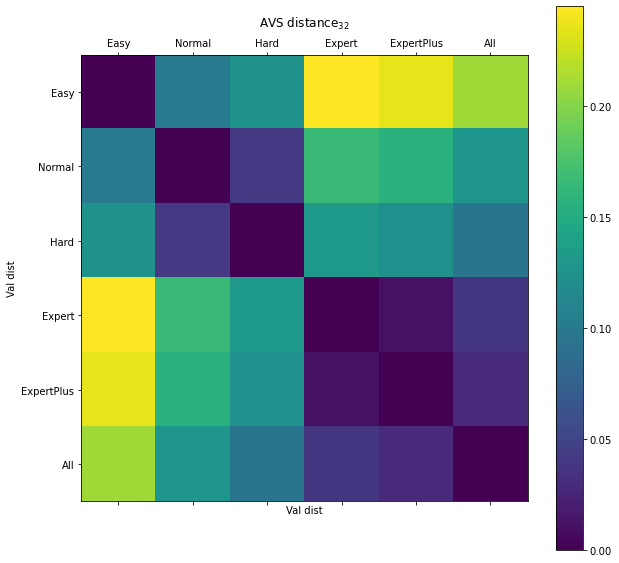

In [48]:
print(avd_distances)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(avd_distances)
plt.title('AVS distance$_{32}$')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.xlabel('Val dist')
plt.ylabel('Val dist')
plt.show()

In [16]:
from process.api import load_datasets, generate_datasets

In [17]:
from utils.types import Config, ROOT_DIR
from process.api import load_datasets, generate_datasets, create_song_list, songs2dataset, normalize_columns

if not in_container:
    def velocities_from_config(config: Config):
        song_folders = create_song_list(config.dataset.beat_maps_folder)
        df = songs2dataset(song_folders, config)
        df_vec = get_vec_df(df)
        generated_velocities_ = compute_multiple_velocities(df_vec)
        return generated_velocities_

generated_velocities = {}

In [52]:
config = Config()
config.base_data_folder = data_folder
config.audio_processing.signal_max_length: float = 2.5e10  # in samples
config.audio_processing.use_cache = False   # default False, set to True if performing multiple times
base_folder = config.base_data_folder
config.dataset.action_word_model_path = data_folder / 'generated_dataset/fasttext.model'

folder_names = [
                'oxai_deepsaber_expert',
                'beat_sage_expert', 
                'deepsaber_MLSTM_expert',
                'deepsaber_vec:id_expert', 
                'deepsaber_vec:vec_expert', 
]

folder_names += [f'human{i}' for i in range(6)]

for folder_name in folder_names:
    if folder_name not in generated_velocities:
        config.dataset.beat_maps_folder = base_folder / 'evaluation_dataset' / folder_name
        config.dataset.storage_folder = base_folder / f'{folder_name}_datasets'
        print(folder_name)
        generated_velocities[folder_name] = velocities_from_config(config)

deepsaber_MLSTM_expert
	Create dataframe from songs in folders:      10 folders
                                                             Recalculated MFCC cache: 9.425782203674316
                                Processing song folders | ########-- |      10


	[process | process_song_folder] Skipped file Beat Sage_ Daft Punk - Harder Better Faster (Official Video) - Warner Music France (v2 HEEN+,SN,D)_generated/Hard | ../../data/evaluation_dataset/deepsaber_MLSTM_expert/Beat Sage_ Daft Punk - Harder Better Faster (Official Video) - Warner Music France (v2 HEEN+,SN,D)_generated:
		'utf-8' codec can't decode byte 0xf3 in position 12: invalid continuation byte


                                            Computed partial dataframes from folders: 6.2096946239471436
                                                               Filtered failed songs: 1.3828277587890625e-05
                                                                  Concatenated songs: 0.02204298973083496
                                                                  Snippets generated: 2.019993305206299
deepsaber_vec:vec_expert
	Create dataframe from songs in folders:      10 folders
                                                             Recalculated MFCC cache: 9.8578941822052
                                Processing song folders | ########-- |      10


	[process | process_song_folder] Skipped file Beat Sage_ Daft Punk - Harder Better Faster (Official Video) - Warner Music France (v2 HEEN+,SN,D)_generated/Hard | ../../data/evaluation_dataset/deepsaber_vec:vec_expert/Beat Sage_ Daft Punk - Harder Better Faster (Official Video) - Warner Music France (v2 HEEN+,SN,D)_generated:
		'utf-8' codec can't decode byte 0xf2 in position 12: invalid continuation byte


                                            Computed partial dataframes from folders: 4.126535892486572
                                                               Filtered failed songs: 1.71661376953125e-05
                                                                  Concatenated songs: 0.023020505905151367
                                                                  Snippets generated: 1.4058585166931152


In [54]:
distances = {}
for folder_name in folder_names:
    gen_vel = generated_velocities[folder_name].items()
    distances[folder_name] = {
        'AVD dist_5': compute_avd_distance(human_velocities_by_diff['Expert'], {key: val for key, val in gen_vel if key < 6}),
        'AVD dist_12': compute_avd_distance(human_velocities_by_diff['Expert'], {key: val for key, val in gen_vel if key < 13}),
        'AVD dist_32': compute_avd_distance(human_velocities_by_diff['Expert'], {key: val for key, val in gen_vel if key < 33}),
    }

In [59]:
res = pd.DataFrame(distances.values(), index=distances.keys())
res.columns = res.columns + '_mean'

index = ['oxai_deepsaber_expert',
         'beat_sage_expert', 
         'deepsaber_vec:vec_expert', 
         'deepsaber_vec:id_expert', 
         'deepsaber_MLSTM_expert',]
res.reindex(index)

AVD dist_5_mean  AVD dist_12_mean  AVD dist_32_mean
oxai_deepsaber_expert            0.542040          0.553989          0.552271
beat_sage_expert                 0.153662          0.150133          0.132929
deepsaber_vec:vec_expert         0.368767          0.327876          0.265771
deepsaber_vec:id_expert          0.102401          0.072299          0.061754
deepsaber_MLSTM_expert           0.086868          0.060201          0.042265

In [60]:
col_formatting = {
    'AVD dist_5': (3, 3),
    'AVD dist_12': (3, 3),
    'AVD dist_32': (3, 3),
}

df_print = formate4latex(res, col_formatting).reindex(index)
print(str(df_print.reset_index(drop=True)))

  AVD dist_5 AVD dist_12 AVD dist_32
0      0.542       0.554       0.552
1      0.154       0.150       0.133
2      0.369       0.328       0.266
3      0.102       0.072       0.062
4      0.087       0.060       0.042


### Human AVD and its deviation on 10 Expert beat maps

In [58]:
res.columns = res.columns.str.replace(r'_mean', '')
human = get_stats(res.loc[res.index.str.contains('human')]).to_frame('human').T
human
df_print = formate4latex(human, col_formatting)
print(str(df_print.reset_index(drop=True)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


         AVD dist_5       AVD dist_12       AVD dist_32
0  0.076$\pm 0.019$  0.070$\pm 0.020$  0.077$\pm 0.016$
